In [ ]:
pip install EMD-signal

In [3]:
import scipy.io.wavfile as wav
import numpy as np
import glob
import signal
from scipy import signal
from pywt import wavedec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
#from PyEMD import EMD

In [ ]:
snimci = [3,6,2,6,7]
pol = 0
train  = []
test = []
filt = 0
x_train = []
y_train = []
x_test = []
y_test = []
N = 50

for i in range(0,len(snimci)):
  if i<2:
    name = 'female'+str(snimci[i])
    pol = 1
  else:
    name = 'male'+str(snimci[i])
    pol = 0
  adress = glob.glob('/content/drive/MyDrive/' + name + '/' + name + '*.wav')
  obiljezja = np.zeros([N,11])
  for j in range(0,N):
    fs,data = wav.read(adress[j])
    # provjera ucestanosti odabiranja
    if fs>16000:
      filt = filt + 1
      b, a = signal.butter(10, 8000/(fs/2), 'low', analog=False, fs = 16000)
      data = signal.lfilter(b, a, data, axis = 0)
      data = signal.resample(data,round(len(data)/fs*16000))
      fs = 16000
    # normalizacija signala
    m = np.mean(data)
    data = data - m
    std = np.std(data)
    data = data / std
    features = np.zeros(11)
    # prvo obiljezje
    features[0] = sum(data**4)/len(data)
    # drugo obiljezje 
    Y = np.fft.fft(data)
    Y = abs(Y)**2
    f  = np.linspace(0,fs,len(Y))
    features[1] = sum(Y[f<150]) - sum(Y[f<100])
    # trece obiljezje
    features[2] = sum(Y[f<300]) - sum(Y[f<200])
    # cetvrto obiljezje
    a,d5,d4,d3,d2,d1 = wavedec(data,'db2',level=5)
    features[3] = sum(d2**2)/len(d2)
    # peto obiljezje
    features[4] = sum(d3**2)/len(d3)
    # sesto obiljezje
    features[5] = sum(d4**2)/len(d4)
    # sedmo obiljezje
    emd = EMD(MAX_ITERATION = 50)
    IMFs = emd(data)
    features[6] = len(IMFs)
    # osmo obiljezje
    m = 500
    widths = np.arange(1, m)
    wt = signal.cwt(data, signal.ricker,widths)
    wt = sum(abs(wt.T)**2)
    wt = wt/(sum(wt))
    features[7] =  sum(wt[44:50])
    # deveto obiljezje
    features[8] = sum(wt[49:55])
    # deseto obiljezje
    features[9] = sum(wt[54:60])
    # klasa
    features[10] = pol
    obiljezja[j,:] = features
  # podjela na trening i test skup
  train, test, yy_train, yy_test = train_test_split(obiljezja[:,0:10], obiljezja[:,10], test_size=0.2)
  if i==0:
      x_train = train
      x_test = test
      y_train = yy_train
      y_test = yy_test
  else:
      x_train = np.concatenate((x_train,train),axis = 0)
      x_test = np.concatenate((x_test,test),axis = 0)
      y_train = np.concatenate((y_train,yy_train),axis = 0)
      y_test = np.concatenate((y_test,yy_test),axis = 0)


In [ ]:
import pandas as pd

x_train_df = pd.DataFrame(x_train)
x_train_df.to_csv('x_train.csv')
!cp x_train.csv "drive/MyDrive/"

y_train_df = pd.DataFrame(y_train)
y_train_df.to_csv('y_train.csv')
!cp y_train.csv "drive/MyDrive/"

x_test_df = pd.DataFrame(x_test)
x_test_df.to_csv('x_test.csv')
!cp x_test.csv "drive/MyDrive/"

y_test_df = pd.DataFrame(y_test)
y_test_df.to_csv('y_test.csv')
!cp y_test.csv "drive/MyDrive/"

In [185]:
# racunanje parametara raspodjele
mean = np.zeros([10,2])
var = np.zeros([10,2])
fi = np.zeros(2)
for i in range(0,2):
  mean[:,i] = np.mean(x_train[y_train==i],axis=0)
  var[:,i] = np.var(x_train[y_train==i],axis=0)
  fi[i] = len(x_train[y_train==i])/len(x_train)

In [ ]:
# klasifikacija 
y_pred = np.zeros(len(y_test))
for i in range(0,len(y_test)):
  p = np.copy(fi)
  for k in range(0,10):
    p = p * 1/(2*np.pi*var[k,:])**0.5*np.exp(-0.5*((x_test[i,k]-mean[k,:])**2/var[k,:]))
  p = p/sum(p)
  y_pred[i] = np.argmax(p)

print(confusion_matrix(y_test,y_pred))

[[30  0]
 [ 0 20]]


In [ ]:
pol = 0
filt = 0
x_Test = []
y_Test = []

for i in range(0,2):
  if i==1:
    name = 'female'
    pol = 1
  else:
    name = 'male'
    pol = 0
  adress = glob.glob('/content/drive/MyDrive/' + name + 'Test/' + name + '*.wav')
  N = len(adress)
  obiljezja = np.zeros([N,11])
  for j in range(0,N):
    fs,data = wav.read(adress[j])
    # provjera ucestanosti odabiranja
    if fs>16000:
      filt = filt + 1
      b, a = signal.butter(10, 8000/(fs/2), 'low', analog=False, fs = 16000)
      data = signal.lfilter(b, a, data, axis = 0)
      data = signal.resample(data,round(len(data)/fs*16000))
      fs = 16000
    # normalizacija signala
    m = np.mean(data)
    data = data - m
    std = np.std(data)
    data = data / std
    features = np.zeros(11)
    # prvo obiljezje
    features[0] = sum(data**4)/len(data)
    # drugo obiljezje 
    Y = np.fft.fft(data)
    Y = abs(Y)**2
    f  = np.linspace(0,fs,len(Y))
    features[1] = sum(Y[f<150]) - sum(Y[f<100])
    # trece obiljezje
    features[2] = sum(Y[f<300]) - sum(Y[f<200])
    # cetvrto obiljezje
    a,d5,d4,d3,d2,d1 = wavedec(data,'db2',level=5)
    features[3] = sum(d2**2)/len(d2)
    # peto obiljezje
    features[4] = sum(d3**2)/len(d3)
    # sesto obiljezje
    features[5] = sum(d4**2)/len(d4)
    # sedmo obiljezje
    emd = EMD(MAX_ITERATION = 50)
    IMFs = emd(data)
    features[6] = len(IMFs)
    # osmo obiljezje
    m = 500
    widths = np.arange(1, m)
    wt = signal.cwt(data, signal.ricker,widths)
    wt = sum(abs(wt.T)**2)
    wt = wt/(sum(wt))
    features[7] =  sum(wt[44:50])
    # deveto obiljezje
    features[8] = sum(wt[49:55])
    # deseto obiljezje
    features[9] = sum(wt[54:60])
    # klasa
    features[10] = pol
    obiljezja[j,:] = features
  if i==0:
      x_Test = obiljezja[:,0:10]
      y_Test = obiljezja[:,10]
  else:
      x_Test = np.concatenate((x_Test,obiljezja[:,0:10]),axis = 0)
      y_Test = np.concatenate((y_Test,obiljezja[:,10]),axis = 0)

In [ ]:
x_Test_df = pd.DataFrame(x_Test)
x_Test_df.to_csv('x_Test.csv')
!cp x_Test.csv "drive/MyDrive/"

y_Test_df = pd.DataFrame(y_Test)
y_Test_df.to_csv('y_Test.csv')
!cp y_Test.csv "drive/MyDrive/"

In [ ]:
# klasifikacija 
y_pred = np.zeros(len(y_Test))
for i in range(0,len(y_Test)):
  p = np.copy(fi)
  for k in range(0,10):
    p = p * 1/(2*np.pi*var[k,:])**0.5*np.exp(-0.5*((x_Test[i,k]-mean[k,:])**2/var[k,:]))
  p = p/sum(p)
  y_pred[i] = np.argmax(p)

print(confusion_matrix(y_Test,y_pred))

[[1132    0]
 [   1  592]]


In [35]:
import pandas as pd

x_test = pd.read_csv('drive/MyDrive/x_test.csv')
x_test.drop(['Unnamed: 0'], axis=1, inplace=True)
y_test = pd.read_csv('drive/MyDrive/y_test.csv')
y_test.drop(['Unnamed: 0'], axis=1, inplace=True)

x_train = pd.read_csv('drive/MyDrive/x_train.csv')
x_train.drop(['Unnamed: 0'], axis=1, inplace=True)
y_train = pd.read_csv('drive/MyDrive/y_train.csv')
y_train.drop(['Unnamed: 0'], axis=1, inplace=True)

x_Test = pd.read_csv('drive/MyDrive/x_Test.csv')
x_Test.drop(['Unnamed: 0'], axis=1, inplace=True)
y_Test = pd.read_csv('drive/MyDrive/y_Test.csv')
y_Test.drop(['Unnamed: 0'], axis=1, inplace=True)

In [36]:
# redukcija broja obiljezja

# normalizacija podataka
x_mean = np.mean(x_train, axis = 0)
x_std = np.std(x_train,axis = 0)
x_train = (x_train - x_mean) / x_std
x_test = (x_test - x_mean) / x_std
x_Test = (x_Test - x_mean) / x_std

In [245]:
# PCA
A = np.matmul(x_train.T, x_train) 
l,Q = np.linalg.eig(A)
l = l /sum(l)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Calling a ufunc on non-aligned DataFrames (or DataFrame/Series combination). Currently, the indices are ignored and the result takes the index/columns of the first DataFrame. In the future , the DataFrames/Series will be aligned before applying the ufunc.
Convert one of the arguments to a NumPy array (eg 'ufunc(df1, np.asarray(df2)') to keep the current behaviour, or align manually (eg 'df1, df2 = df1.align(df2)') before passing to the ufunc to obtain the future behaviour and silence this warning.
  


In [23]:
def cdf(niz):

  l = np.copy(niz)
  for i in range(1,len(l)):
    l[i] += l[i-1]

  return l

In [11]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'suma')

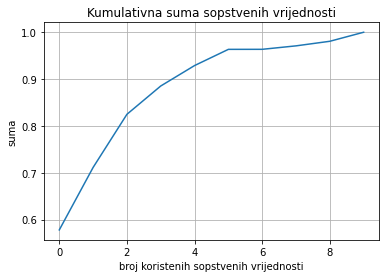

In [247]:
plt.plot(cdf(l))
plt.grid()
plt.title('Kumulativna suma sopstvenih vrijednosti')
plt.xlabel('broj koristenih sopstvenih vrijednosti')
plt.ylabel('suma')

In [248]:
x_train_red = np.dot(x_train,Q)[:,0:4]
x_test_red = np.dot(x_test,Q)[:,0:4]
x_Test_red = np.dot(x_Test,Q)[:,0:4]

mean = np.zeros([4,2])
var = np.zeros([4,2])
fi = np.zeros(2)
for i in range(0,2):
  mean[:,i] = np.mean(x_train_red[y_train['0']==i],axis=0)
  var[:,i] = np.var(x_train_red[y_train['0']==i],axis=0)
  fi[i] = len(x_train_red[y_train['0']==i])/len(x_train_red)

In [249]:
klasifikacija(x_test_red,y_test)

array([[30,  0],
       [ 0, 20]])

In [250]:
klasifikacija(x_Test_red,y_Test)

array([[1127,    5],
       [   9,  584]])

In [184]:
100 - 100*(5+9)/(1127+5+9+584)

99.18840579710145

In [37]:
# LDA
mean = np.zeros([10,2])
var = np.zeros([10,10,2])
fi = np.zeros(2)
for i in range(0,2):
  mean[:,i] = np.mean(x_train[y_train['0']==i],axis=0)
  var[:,:,i] = np.cov(x_train[y_train['0']==i].T)
  fi[i] = len(x_train[y_train['0']==i])/len(x_train)

M0 = fi[0] * mean[:,0] + fi[1] * mean[:,1]
Sw = fi[0] * var[:,:,0] + fi[1] * var[:,:,1]
Sb = fi[0] * np.matmul(np.reshape(mean[:,0] - M0,[10,1]), np.reshape(mean[:,0] - M0,[1,10]))
Sb = Sb + fi[1] * np.matmul(np.reshape(mean[:,1] - M0,[10,1]), np.reshape(mean[:,1] - M0,[1,10])) 

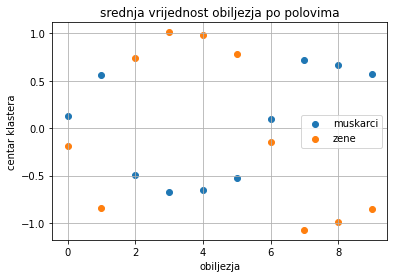

In [38]:
plt.scatter(range(0,10),mean[:,0])
plt.scatter(range(0,10),mean[:,1])
plt.grid()
plt.xlabel('obiljezja')
plt.ylabel('centar klastera')
plt.title('srednja vrijednost obiljezja po polovima')
plt.legend(['muskarci','zene'])

Text(0.5, 1.0, 'Vrijednosti sopstvenog vektora koji se zadrzava')

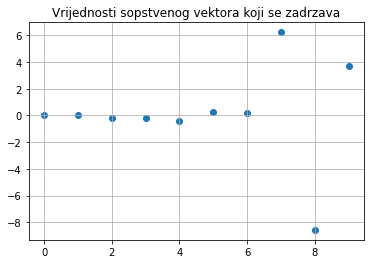

In [43]:
Q = np.real(Q)
plt.scatter(range(0,10),Q[:,0]/sum(Q[:,0]))
plt.grid()
plt.title('Vrijednosti sopstvenog vektora koji se zadrzava')

Text(0, 0.5, 'suma')

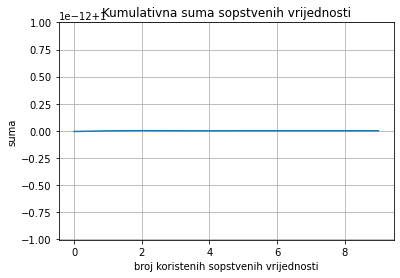

In [40]:
A = np.matmul(np.linalg.inv(Sw),Sb)
l,Q = np.linalg.eig(A)
l = np.real(l)
l = l /sum(l)

plt.plot(cdf(l))
plt.grid()
plt.title('Kumulativna suma sopstvenih vrijednosti')
plt.xlabel('broj koristenih sopstvenih vrijednosti')
plt.ylabel('suma')

In [45]:
x_train_red = np.dot(x_train,Q[:,0].T)
x_test_red = np.dot(x_test,Q[:,0].T)
x_Test_red = np.dot(x_Test,Q[:,0].T)

In [46]:
mean = np.zeros([1,2])
var = np.zeros([1,2])
fi = np.zeros(2)
for i in range(0,2):
  mean[:,i] = np.mean(x_train_red[y_train['0']==i],axis=0)
  var[:,i] = np.var(x_train_red[y_train['0']==i],axis=0)
  fi[i] = len(x_train_red[y_train['0']==i])/len(x_train_red)

In [47]:
def klasifikacija(x,y):

  x = np.array(x)
  y_pred = np.zeros(len(y))
  if len(x.shape)>1:
    d = x.shape[1]
  else:
    d = 1
    x = np.reshape(x,[len(x),1])
  for i in range(0,len(y_pred)):
    p = np.copy(fi)
    for k in range(0,d):
      p = p * 1/(2*np.pi*var[k,0:d+1])**0.5*np.exp(-0.5*((x[i,k]-mean[k,0:d+1])**2/var[k,0:d+1]))
    p = p/sum(p)
    y_pred[i] = np.argmax(p)

  return confusion_matrix(y,y_pred)

In [48]:
klasifikacija(x_test_red,y_test)

array([[30,  0],
       [ 0, 20]])

In [49]:
klasifikacija(x_Test_red,y_Test)

array([[1132,    0],
       [   0,  593]])